In [1]:
matrix_destination = "matrix.cellQC.geneQC.normalised.hk_controls.ccClean.rds"
source("load_matrix.R")

Loading required package: SummarizedExperiment
Loading required package: GenomicRanges
Loading required package: stats4
Loading required package: BiocGenerics
Loading required package: parallel

Attaching package: ‘BiocGenerics’

The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs

The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, cbind, colMeans, colnames,
    colSums, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, lengths, Map, mapply, match,
    mget, order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rowMeans, rownames, rowSums, sapply, setdiff, sort,
    table, tapply, union, unique, unsp

# Removing (other) confounder effects

We should remove technical covariates that may arise from complex experimental designs, such as those from batch effects.

First we should note that our data has very minor batch effects from the different plates that it was loaded from, and we can confirm this both with a histogram of the library size, and with a PCA:

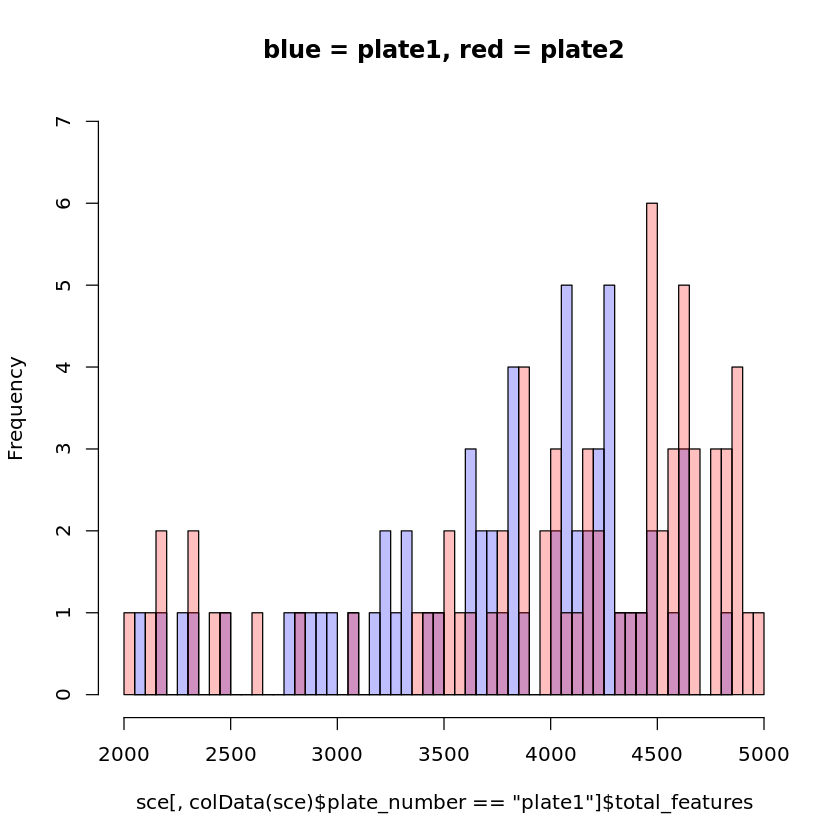

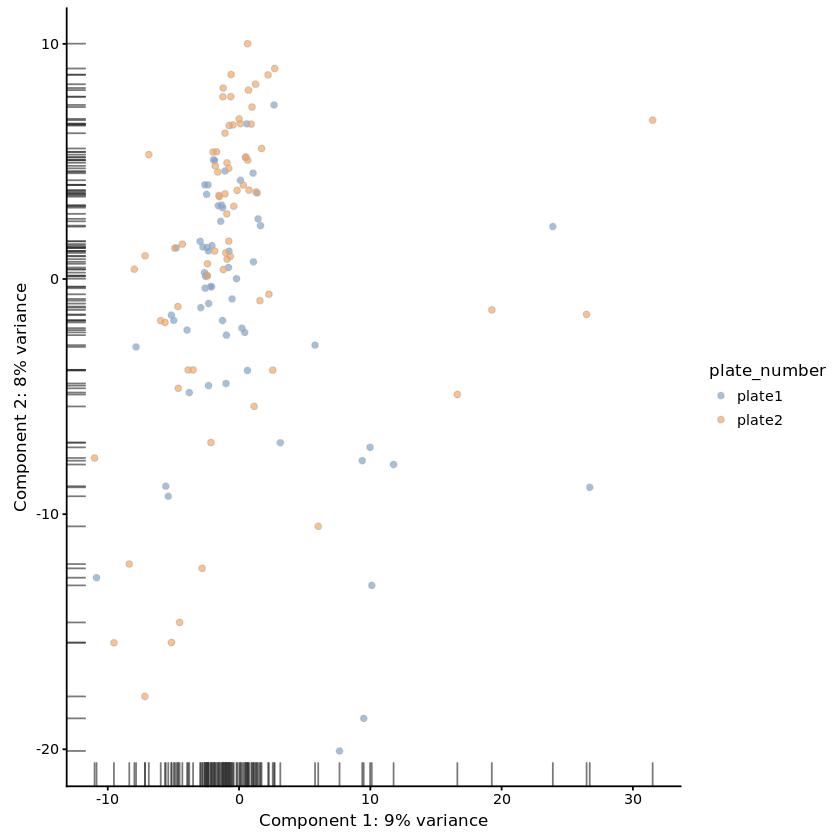

In [2]:
q1 <- hist(sce[,colData(sce)$plate_number == "plate1"]$total_features, breaks = 50,
        main = "blue = plate1, red = plate2",
        xlim=c(2000,5000), ylim=c(0,7), col=rgb(0,0,1,1/4))
q2 <- hist(sce[,colData(sce)$plate_number == "plate2"]$total_features, breaks = 50,
        xlim=c(2000,5000), ylim=c(0,7), col=rgb(1,0,0,1/4), add= T)


plotPCA(
    sce,
    colour_by = "plate_number",
    #size_by = "total_features",
    #exprs_values = "counts"
    exprs_values = "logcounts"
)


From here we can see that both the red and blue plates follow very similar (noisy) profiles in histograms, and in the PCA we can see some many similarities in where the cells from each plate normally cluster (top-left) with some differences in their outliers.

For this we will need to fit a general linear model (GLM), and we consider four methods:

 * **ZinbWave** - A GLM that works on zero-inflated models
 * **removeBatchEffect** - A Limma general purpose function to correct for different batches
 * **Combat** - Uses a heirarchal model to remove row-specific batch-effects
 * **GLM** - Native function `glm()`
 

In [3]:
## TODO: fix mnnCorrect...
library(limma)
library(data.table)
library(sva)

# Apply RBE
assay(sce, "rbe") <- removeBatchEffect(logcounts(sce), batch=sce$plate_number)

# Apply GLM
glm_fun <- function(g, batch) {
  model <- glm(g ~ batch)
  model$coef[1] <- 0 # replace intercept with 0 to preserve reference batch.
  return(model$coef)
}
effects <- apply(
    logcounts(sce), 
    1, 
    glm_fun, 
    batch = sce$plate_number
)
corrected <- logcounts(sce) - t(effects[as.numeric(factor(sce$plate_number)), ])
assay(sce, "glm") <- corrected

# Apply Combat
combat_data <- logcounts(sce)
mod_data <- as.data.frame(t(combat_data))
mod0 = model.matrix(~ 1, data = mod_data)                      # batch remove 
mod2 = model.matrix(~ sce$total_features, data = mod_data) # adjust for total genes detected
assay(sce, "combat") <- ComBat(
    dat = t(mod_data), 
    batch = factor(sce$plate_number), 
    mod = mod0,
    par.prior = TRUE,
    prior.plots = FALSE
)



Attaching package: ‘limma’

The following object is masked from ‘package:scater’:

    plotMDS

The following object is masked from ‘package:BiocGenerics’:

    plotMA


Attaching package: ‘data.table’

The following object is masked from ‘package:SummarizedExperiment’:

    shift

The following object is masked from ‘package:GenomicRanges’:

    shift

The following object is masked from ‘package:IRanges’:

    shift

The following objects are masked from ‘package:S4Vectors’:

    first, second

Loading required package: mgcv
Loading required package: nlme

Attaching package: ‘nlme’

The following object is masked from ‘package:IRanges’:

    collapse

This is mgcv 1.8-23. For overview type 'help("mgcv-package")'.
Loading required package: genefilter

Attaching package: ‘genefilter’

The following objects are masked from ‘package:matrixStats’:

    rowSds, rowVars

Loading required package: BiocParallel
Found2batches
Adjusting for0covariate(s) or covariate level(s)


Standardizing Data across genes


Fitting L/S model and finding priors
Finding parametric adjustments
Adjusting the Data



In [4]:
# Apply zinbwave (takes ~ 1 hr)
library(zinbwave)
sce_zinb <- zinbwave(sce, K=50, X = "~ plate_number", residuals = TRUE, normalizedValues = TRUE)


In [5]:
library(scRNA.seq.funcs)
assay(sce, "zinbnorm") <- normcounts(sce_zinb)   # zinb returns normalised values
assay(sce, "zinblog") <- logcounts(sce_zinb)   # zinb returns normalised values
assay(sce, "zinb") <- counts(sce_zinb)   # zinb returns normalised values

plotAssay <- function(tuple_list, cols = NULL){
    if (is.null(cols)) cols = 2
    
    for(tuple in tuple_list){
        i <- 0
        glob <- list()
        for (tup in tuple){
            i <- i + 1
            
            q <- plotPCA(sce,
                    colour_by = "plate_number",
                    size_by = "total_features",
                    exprs_values = tup                    
            ) +  theme(legend.position = c(2, 0), legend.justification = c(0, 1)) + ggtitle(tup)
            
            glob[[i]] <- q

        }
        multiplot(plotlist = glob, cols = cols)
    }
}



#res <- list()
#for(n in test_c) {
#    res[[n]] <- suppressWarnings(calc_cell_RLE(assay(sce, n)))
#}
#par(mar=c(6,4,1,1))
#boxplot(res, las=2)

### ZinbWave

Let us see whether Zinbwave made any significant changes to the overall clustering:

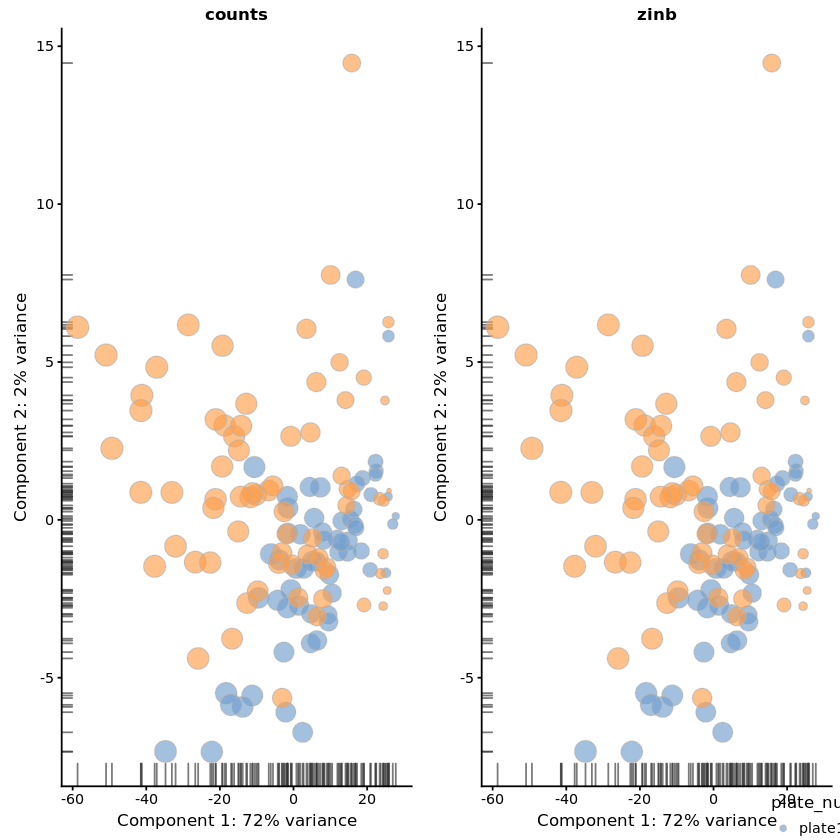

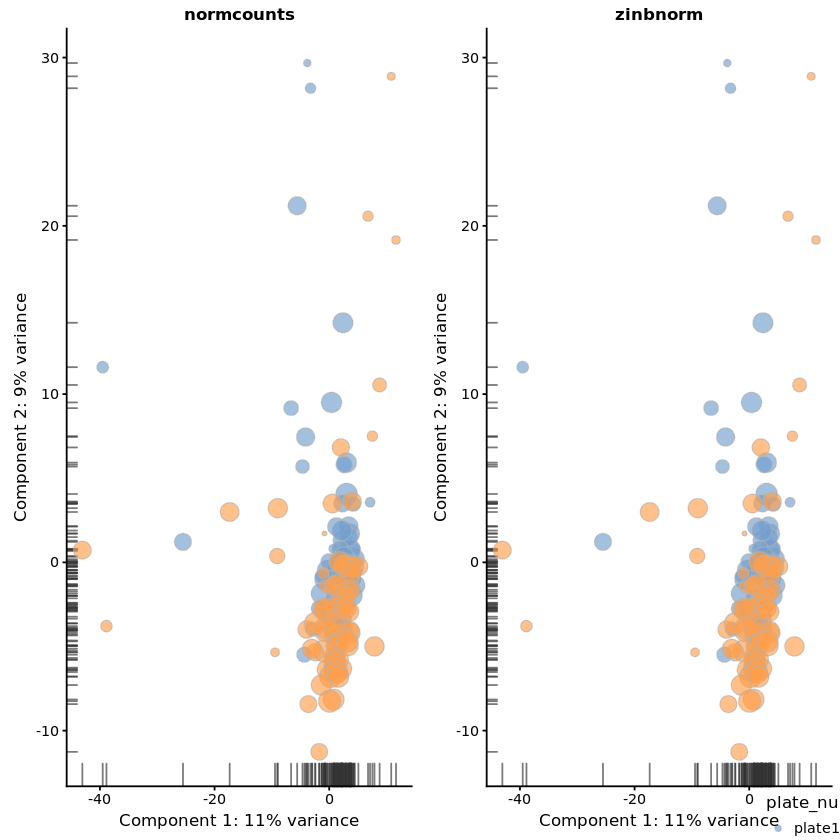

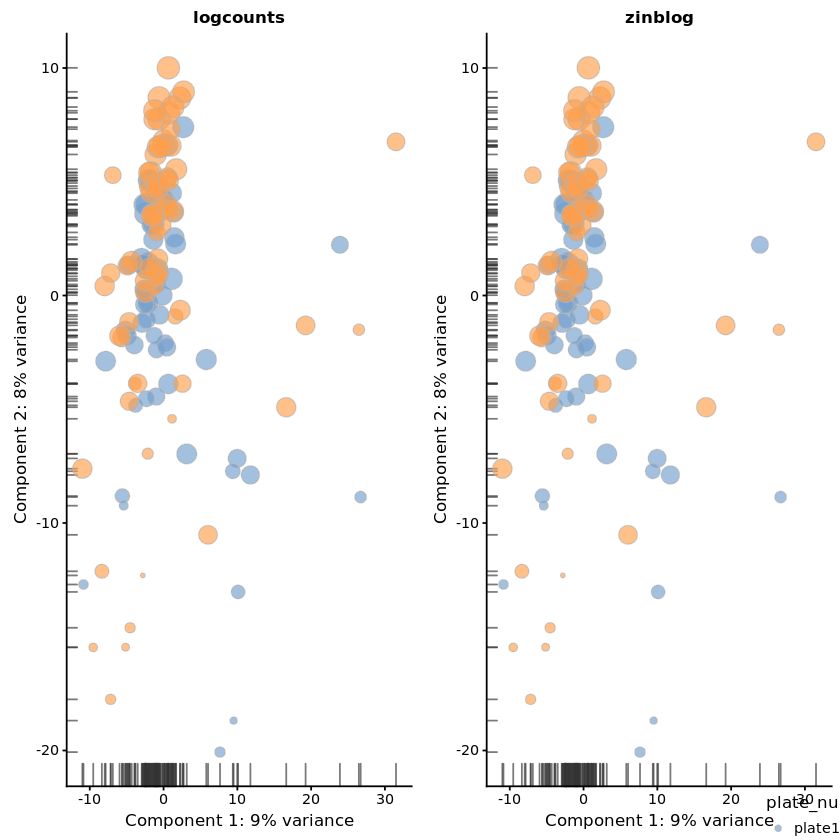

[1] 2


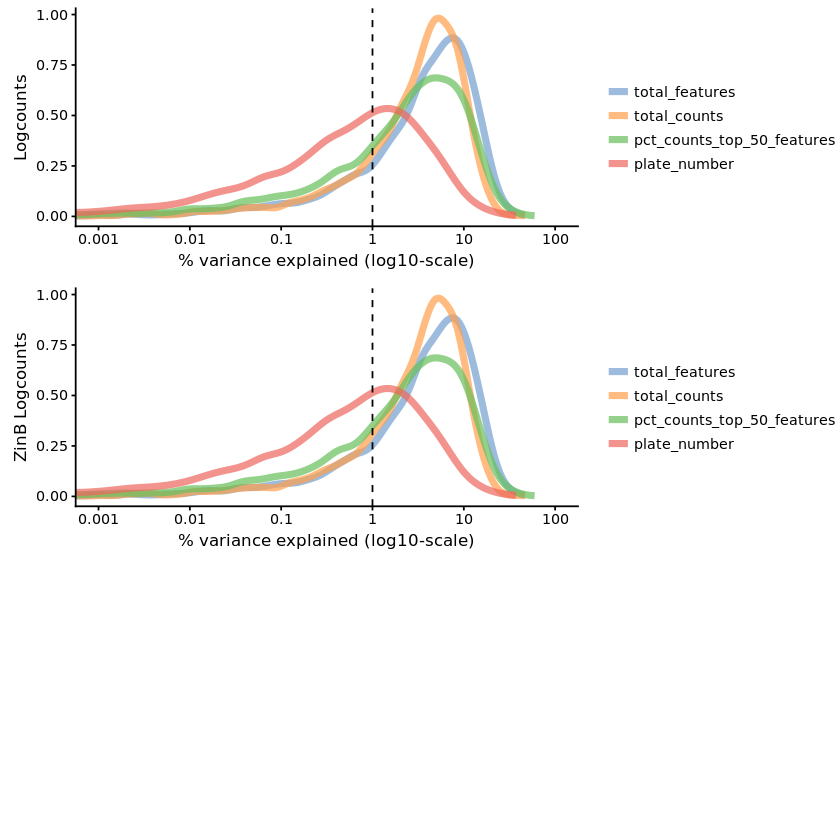

In [6]:
test_c <- list( c("counts", "zinb"),  c("normcounts", "zinbnorm"), c("logcounts", "zinblog"))
plotAssay(test_c)

multiplot(
    plotQC(sce, type = "expl", exprs_values = "logcounts", variables = c(
    "plate_number","total_features", "total_counts", "pct_counts_top_50_features"
    )) + ylab("Logcounts"),
    plotQC(sce, type = "expl", exprs_values = "zinblog", variables = c(
    "plate_number","total_features", "total_counts", "pct_counts_top_50_features"
    )) + ylab("ZinB Logcounts"),
    rows = 2
)

ZinbWave appears to have not produced any discernible changes in any of its computed assays, either hinting that batch effects are not a concern, or that they were filtered out in a former QC step, or that batch effects are immeasurable for this data.

## RemoveBatchEffect

Let us see what the outcome of the RBE was:

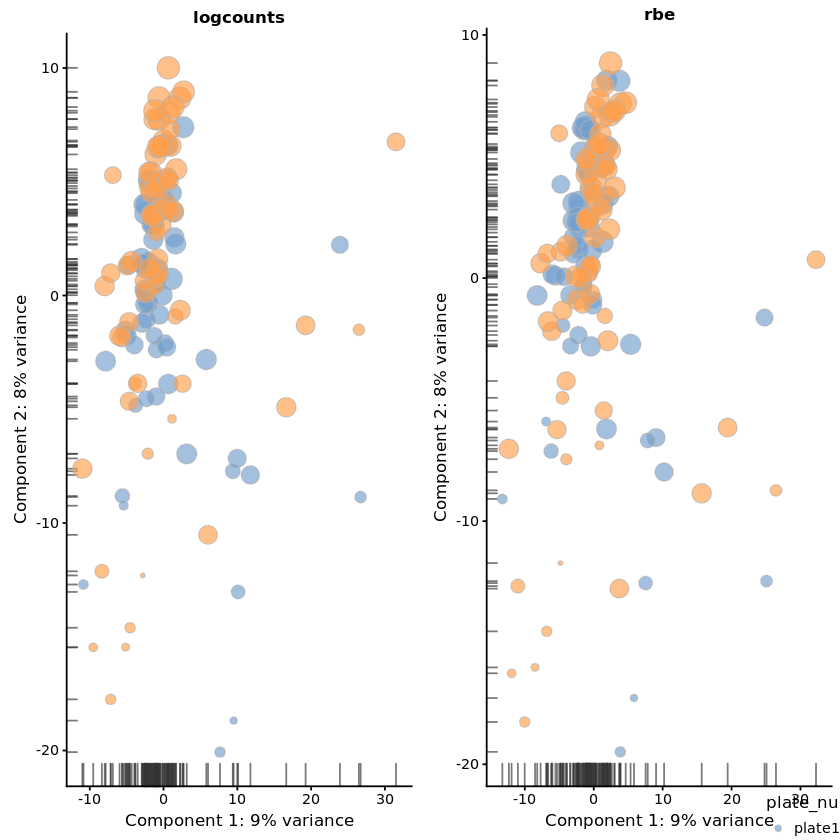

[1] 2


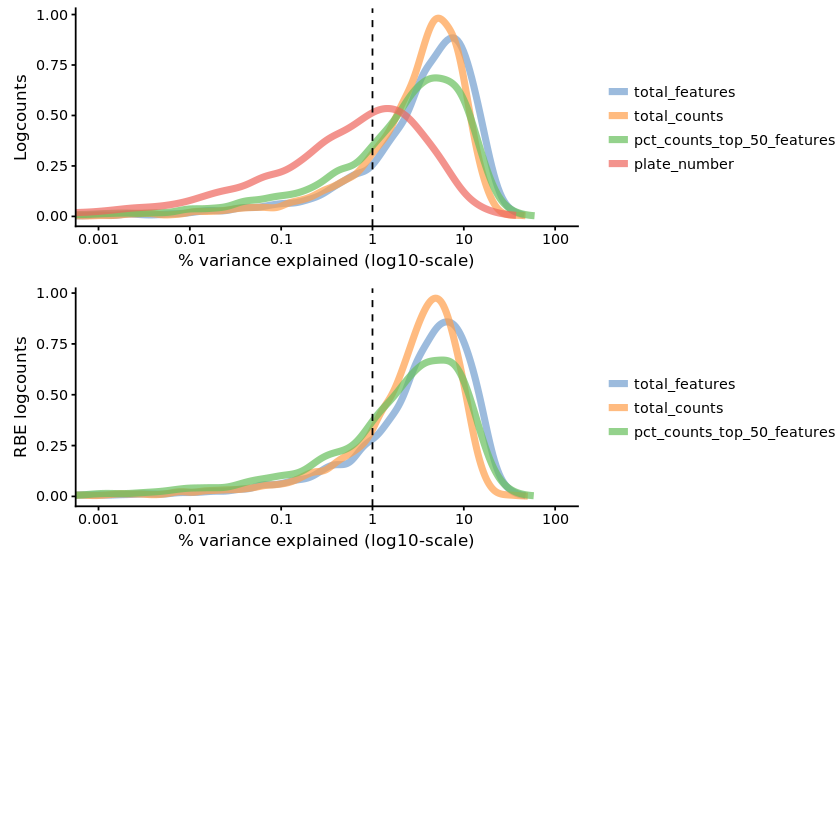

In [7]:
test_c <- list( c("logcounts", "rbe"))
plotAssay(test_c)

multiplot(
    plotQC(sce, type = "expl", exprs_values = "logcounts", variables = c(
    "plate_number","total_features", "total_counts", "pct_counts_top_50_features"
    )) + ylab("Logcounts"),
    plotQC(sce, type = "expl", exprs_values = "rbe", variables = c(
    "plate_number","total_features", "total_counts", "pct_counts_top_50_features"
    )) + ylab("RBE logcounts"),
    rows = 2
)

#multiplot(
#    plotQC(sce, type = "expl", exprs_values = "logcounts", method="pairs", variables = c(
#    "plate_number","total_features", "total_counts", "pct_counts_top_50_features"
#    )) + ylab("Logcounts"),
#    plotQC(sce, type = "expl", exprs_values = "rbe", method="pairs", variables = c(
#    "plate_number","total_features", "total_counts", "pct_counts_top_50_features"
#    )) + ylab("RBE logcounts"),
#    rows = 2
#)

RBE had a much more noticeable effect on the batch data, with cells from different plates overlapping more concordantly. The plate_number effect on the variance explained chart appears to have disappeared completely (below the minimal value ( = 0) required for median marginal R-squared for it to be plotted)

## Combat

Let us evaluate the effect of applying Combat

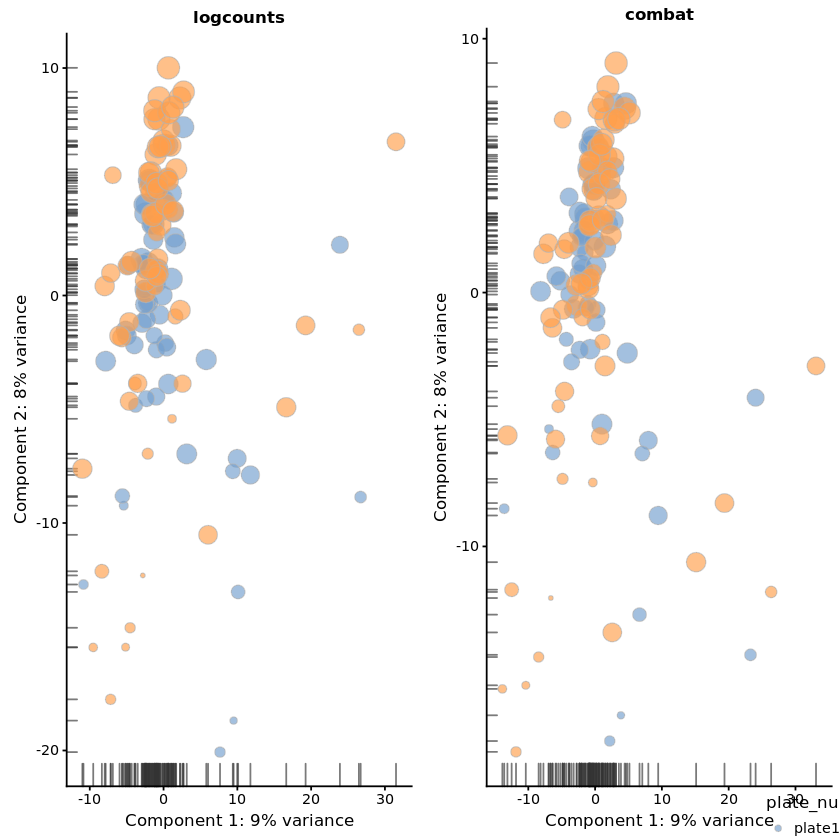

[1] 2


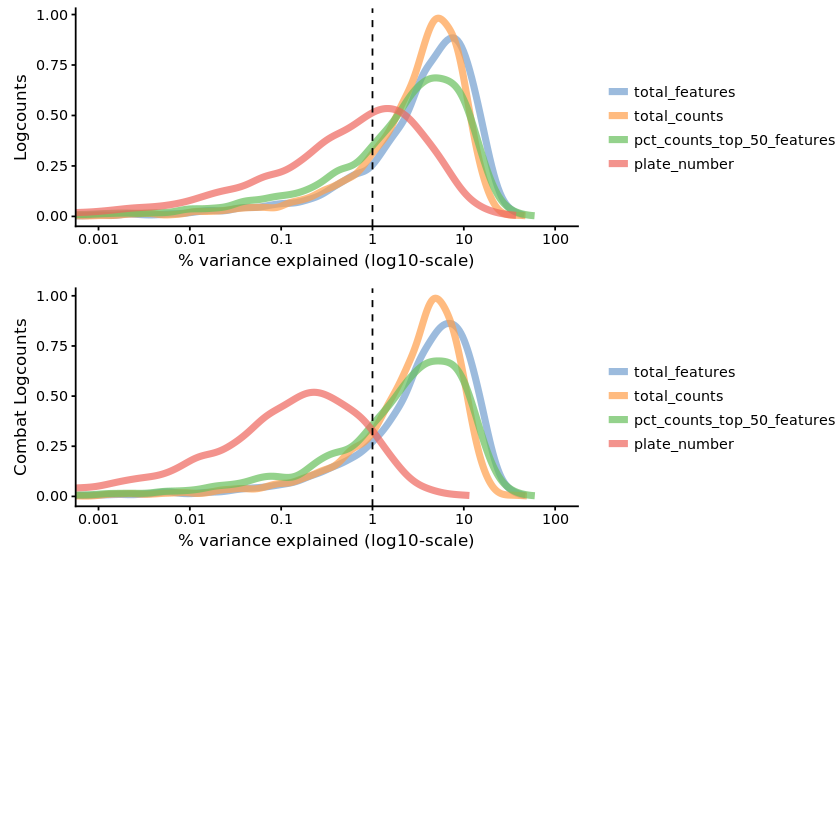

In [8]:
test_c <- list( c("logcounts", "combat") )
plotAssay(test_c)

multiplot(
    plotQC(sce, type = "expl", exprs_values = "logcounts", variables = c(
    "plate_number","total_features", "total_counts", "pct_counts_top_50_features"
    )) + ylab("Logcounts"),
    plotQC(sce, type = "expl", exprs_values = "combat", variables = c(
    "plate_number","total_features", "total_counts", "pct_counts_top_50_features"
    )) + ylab("Combat Logcounts"),
    rows = 2
)

#multiplot(
#    plotQC(sce, type = "expl", exprs_values = "logcounts", method = "pairs", variables = c(
#    "plate_number","total_features", "total_counts", "pct_counts_top_50_features"
#    )) + ylab("Logcounts"),
#    plotQC(sce, type = "expl", exprs_values = "combat", method = "pairs", variables = c(
#    "plate_number","total_features", "total_counts", "pct_counts_top_50_features"
#    )) + ylab("Combat Logcounts"),
#    rows = 2
#)

Here we can see that Combat has significantly(!) reduced the variance contributed by the plate_number, whilst preserving the density of the counts.

### Standard GLM

Let us view how a standard general purpose GLM affects our data:

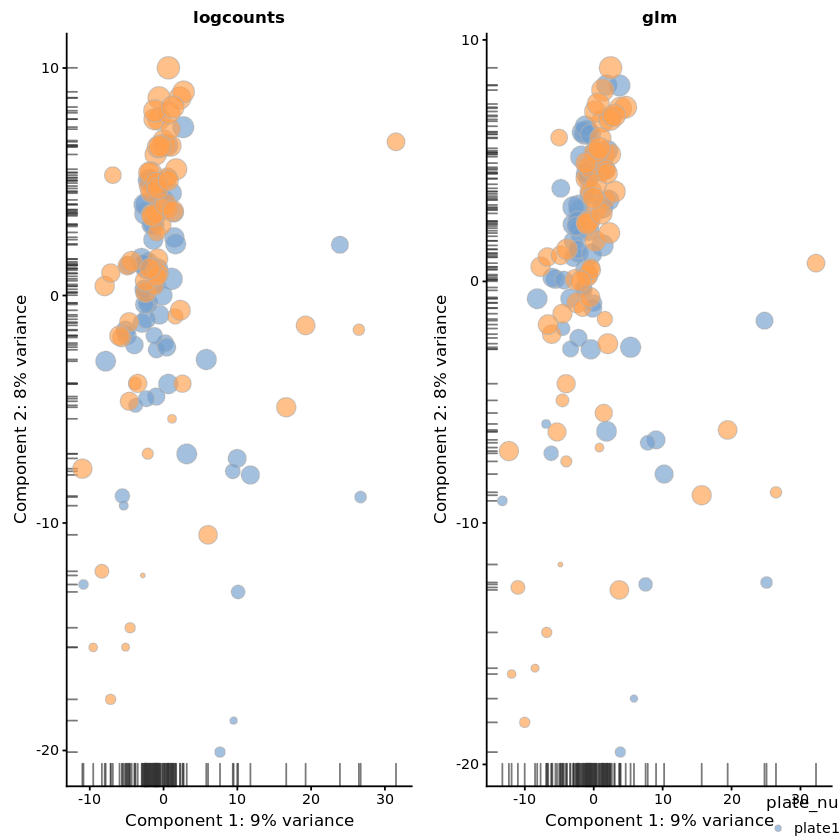

[1] 2


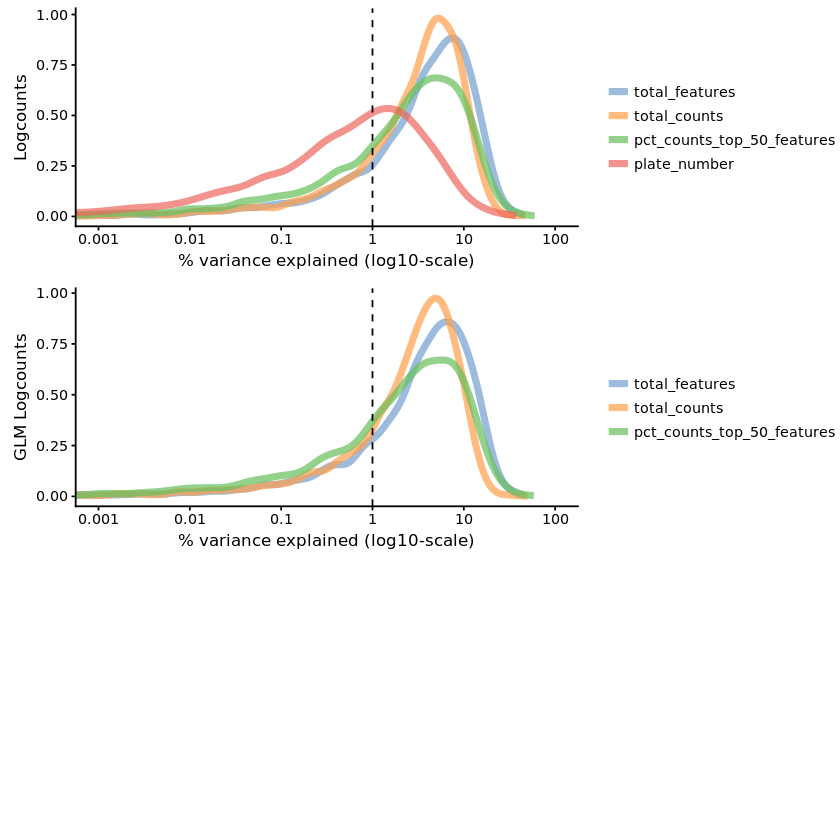

In [9]:
test_c <- list( c("logcounts", "glm"))
plotAssay(test_c)

multiplot(
    plotQC(sce, type = "expl", exprs_values = "logcounts", variables = c(
    "plate_number","total_features", "total_counts", "pct_counts_top_50_features"
    )) + ylab("Logcounts"),
    plotQC(sce, type = "expl", exprs_values = "glm", variables = c(
    "plate_number","total_features", "total_counts", "pct_counts_top_50_features"
    )) + ylab("GLM Logcounts"),
    rows = 2
)

It appears that a standard GLM appears to have the same effect as RBE.

### Overview of (effective) confounding effect removers:

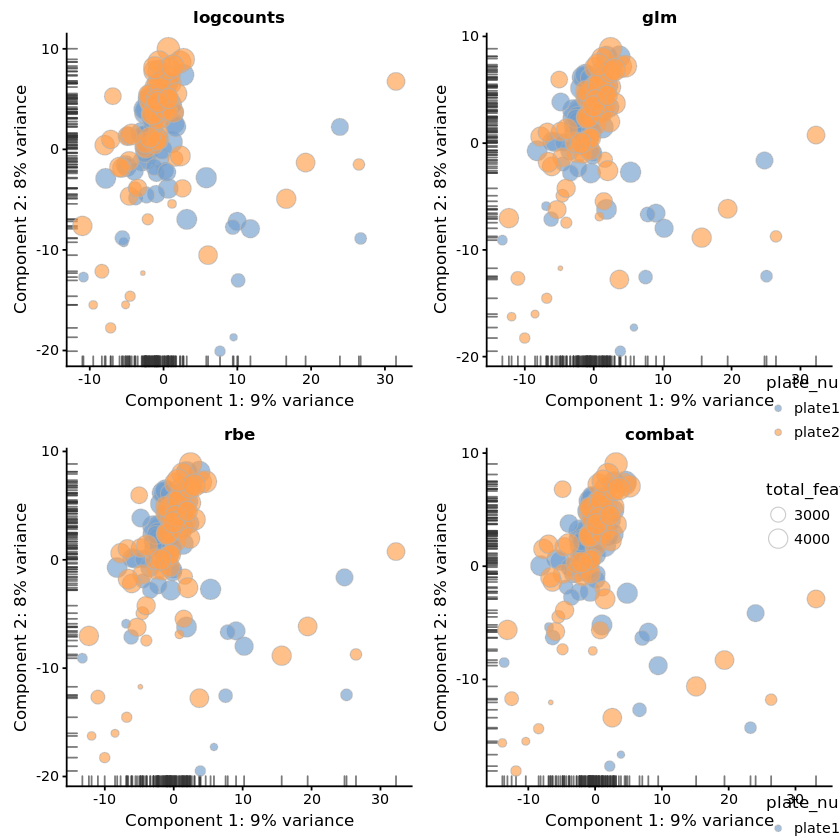

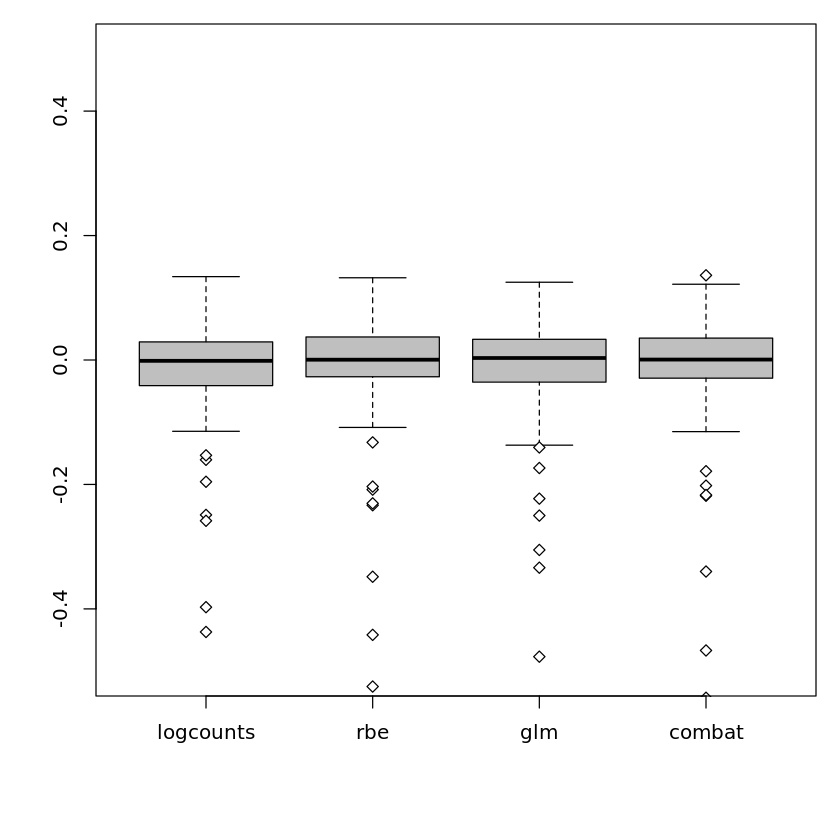

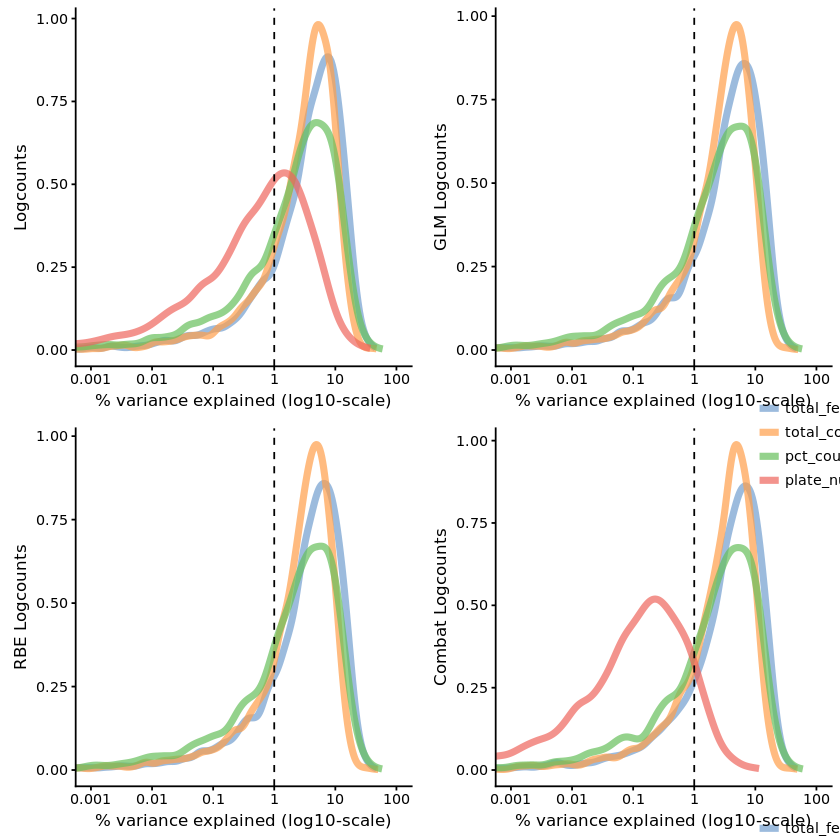

In [10]:
assays <- c("logcounts", "rbe", "glm", "combat")
test_c <- list( assays )
plotAssay(test_c, 2)


res <- list()
for(n in assays){
    res[[n]] <- suppressWarnings(calc_cell_RLE(assay(sce, n)))
}
par(mar=c(6,4,1,1))
boxplot(res, col = rgb(0,0,0,1/4), pch=23, na.rm = T, ylim = c(-1/2,1/2))

multiplot(
    plotQC(sce, type = "expl", exprs_values = "logcounts", variables = c(
    "plate_number","total_features", "total_counts", "pct_counts_top_50_features"
    )) + ylab("Logcounts") + theme(legend.position = c(2, 0), legend.justification = c(0, 1)),
    plotQC(sce, type = "expl", exprs_values = "rbe", variables = c(
    "plate_number","total_features", "total_counts", "pct_counts_top_50_features"
    )) + ylab("RBE Logcounts") + theme(legend.position = c(2, 0), legend.justification = c(0, 1)),
    plotQC(sce, type = "expl", exprs_values = "glm", variables = c(
    "plate_number","total_features", "total_counts", "pct_counts_top_50_features"
    )) + ylab("GLM Logcounts") + theme(legend.position = c(2, 0), legend.justification = c(0, 1)),
    plotQC(sce, type = "expl", exprs_values = "combat", variables = c(
    "plate_number","total_features", "total_counts", "pct_counts_top_50_features"
    )) + ylab("Combat Logcounts") + theme(legend.position = c(2, 0), legend.justification = c(0, 1)),
    cols = 2
)


The differences in the PCAs appear to be almost nominal, but a look at the the relative log expression of the different assays shows that there are some noteworthy features:
 * The overall number of outliers remains constant across assays and are primarily on the lower-end of the spectrum, with the exception of combat which has an upper-limit outlier.
 * **Combat** has the smallest upper-limit of all and a reasonably balanced distribution in contrast to **RBE** and **GLM** which are bottom and top skewed respectively.
 * All assays do not alter the explanatory power of the number of counts and number of features, but rightfully only correct for the plate_number. 
  * **GLM** and **RBE** do not show the plate effect, and it is unlikely that they have completely removed it from the data, so the effectiveness of their corrections are somewhat dubuious.
  * **Combat** has unequivocally reduced the plate_number variance.
  
We shall proceed with the combat-corrected assay.

In [11]:
# remove other assays
assay(sce, "zinbnorm") <- NULL
assay(sce, "zinblog") <- NULL
assay(sce, "zinb") <- NULL
assay(sce, "glm") <- NULL
assay(sce, "rbe") <- NULL

assay(sce, "logcounts") <- assay(sce, "combat") # replace
assay(sce, "combat") <- NULL # wipe old

#assays(sce)
#plotQC(sce, type = "expl", exprs_values = "logcounts", variables = c(
#    "plate_number","total_features", "total_counts", "pct_counts_top_50_features"
#)) + ylab("Logcounts") + theme(legend.position = c(2, 0), legend.justification = c(0, 1))

In [12]:
saveRDS(sce, "matrix.cellQC.geneQC.normalised.hk_controls.ccClean.combat.rds")